# Yet another way to solve the Schrodinger equation 

We have seen how to solve the Schrodinger equation for bound state energies and wave functions using a matrix representation in coordinate space, a matrix representation in a harmonic oscillator basis, and using path integrals. In this notebook we add another method to the list: direct solution of the S-equation in coordinate space as a differential equation using finite difference methods.


## Solving as a differential equation in coordinate representation.
This works when we have a *local* potential (otherwise the Schrodinger equation is an integro-differential equation in coordinate representation).
If we have a central potential in three dimensions, the potential depends only on $r$: 

$$
    V({\bf x}) = V(|{\bf x}|) \equiv V(r)
   \ ,
$$

and we can use a partial wave decomposition (which means we 
    separate the equation in spherical coordinates).  That is, we write 

$$
   \Psi_{nlm}({\bf x}) = \frac{u_{nl}(r)}{r} Y_{lm}(\theta,\phi) \ ,
$$

where $Y_{lm}$ is a spherical harmonic, and solve the radial one-dimensional Schrodinger equation:

$$
   -\frac{\hbar^2}{2M}\frac{d^2u_{nl}(r)}{dr^2}
   +  
   \underbrace{\biggl[
     V(r) + \frac{\hbar^2 l (l+1)}{2M r^2}
               \biggr]}_{\equiv V_{\rm eff}(r)} 
    u_{nl}(r)
  = E_n u_{nl}(r)
  \ ,
  \label{eq:radSE}
$$

with

$$
  u_{nl}(r=0) = 0  \qquad \mbox{and} \qquad
    \int_0^\infty |u_{nl}(r)|^2\, dr = 1 \ .
    \label{eq:radbc}
$$  

We'll apply this method here for radial equations with a central potential.



For the Coulomb potential $V(r)= -Ze^2/r$, we use the notation $N$ instead of $n$ for the number of nodes and define

$$ n = N + \ell + 1, $$

because the energies will only depend on $n$ (more precisely, on $1/n^2$). 

## Solving the differential equation using a finite difference method

Here we use a (crude) finite difference formula for the second derivative in the kinetic energy operator (here with notation appropriate to the radial equation in spherical coordinates and $h \equiv \Delta x$):

$$
   \frac{d^2u}{dr^2} = \frac{u(r+h) - 2 u(r) + u(r-h)}{h^2} + {\cal O}(h^2) .
$$

You can verify this approximation by expanding $u(r+h)$ and $u(r-h)$ in
 Taylor series about $u(r)$.
We'll label the points:

$$
   r_i = i\times h\ , \qquad i = 0,1,2,\cdots,N-1
$$ 
 
 where $N$ is the number of steps and the step size $h$ is given by:
 
$$
   h = \frac{R_{\rm max}}{N-1} .
$$

Thus, $r_0 = 0$, $r_1 = h$, and so on up to $r_{N} = (N-1)h = R_{\rm
 max}$.  
 
We can rearrange the equation to let us determine the radial wave function $u(r)$ at successive steps in $h$, given the previous two values of $u$:

\begin{align}
   u(r+h) &= 2 u(r) - u(r-h) + h^2\frac{d^2u}{dr^2} \\
          &= 2 u(r) - u(r-h) + h^2\left[\frac{2m}{\hbar^2}(V_{\rm eff}(r)-E)  \right]u(r)
\end{align}

For $h>0$ we integrate out from the origin, starting with two initial values, while for $h < 0$ we integrate in from a sufficiently large value of $r$ (our approximation to $\infty$), where "sufficiently large" means that we are in the asymptotic region.  
 
 
 

In [1]:
import numpy as np
from scipy.integrate import quad, simps, solve_ivp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid"); sns.set_context("talk")


### 1. Set Hamiltonian constants, nodes and $\ell$, and mesh/iteration parameters

If we set the important quantities $\hbar$, $m$, and $Ze^2$ all equal to one (i.e., we measure in units where these are one), then the exact energy eigenvalues are

$$
  E_n = -\frac{1}{2n^2}.
$$

In [2]:
# values of constants (choose natural units)
hbar = 1;
mass = 1;  
Ze_sq = 1;   # Z factor (Z = 1 for hydrogen) times electron charge squared

**Here is where you set the desired number of nodes and the value of $\ell$. You might also want to change the initial guess of `E_trial` for some choices of nodes and $\ell$.**

In [3]:
nodes = 0  # desired number of nodes in radial wave function
ell = 0    # orbital angular momentum quantum number
E_trial = -0.1      # initial guess for the trial wf
DeltaE_nodes = .02  # small increment in energy if no. of nodes is incorrect
iter_max = 40  # maximum number of iterations

**Here is where you can adjust the properties of the radial mesh, 
such as the number of points, the maximum $r$ value (which together sets $h \equiv \Delta r$).
Particularly important is that you set the matching index `i_match`, which you will have to adjust
when you change the number of nodes and the value of $\ell$.**

In [4]:
N_pts = 2001   # For accuracy this should be large; over 1000 
r_min = 0.     # For three-dimensions, r starts at zero
r_max = 20.    # How large to make this depends on the potential
Delta_r = (r_max - r_min) / (N_pts - 1)
r_mesh = np.linspace(r_min, r_max, N_pts)  # create the grid ("mesh") of x points
i_match = int(N_pts / 4)   # where to match in and out solutions (adjust as needed)

In [5]:
C_out = 1.  # coefficient for approximate analytic solution near origin
D_in = 1.e-40  # coefficient for approximate analytic solution at large r
DeltaE_tol = 0.0001  # stop iterating when DeltaE_trial < DeltaE_tol

In [6]:
u_out = np.zeros(N_pts)   # initialize array for radial wf from outward integration
u_in = np.zeros(N_pts)    # initialize array for radial wf from inwar integration
u_trial = np.zeros(N_pts) # initial array for scaled and joined radial wf 

### 2. Main iteration
Keep going until `DeltaE_trial` is less than (or equal to) `DeltaE_tol`.


**** Iteration #1
nodes: 1, E_trial: -0.1200, Delta E_trial: 0.00020

**** Iteration #2
nodes: 1, E_trial: -0.1400, Delta E_trial: 0.00020

**** Iteration #3
nodes: 1, E_trial: -0.1600, Delta E_trial: 0.00020

**** Iteration #4
nodes: 1, E_trial: -0.1800, Delta E_trial: 0.00020

**** Iteration #5
nodes: 1, E_trial: -0.2000, Delta E_trial: 0.00020

**** Iteration #6
nodes: 1, E_trial: -0.2200, Delta E_trial: 0.00020

**** Iteration #7
nodes: 1, E_trial: -0.2400, Delta E_trial: 0.00020

**** Iteration #8
nodes: 1, E_trial: -0.2600, Delta E_trial: 0.00020

**** Iteration #9
nodes: 1, E_trial: -0.2800, Delta E_trial: 0.00020

**** Iteration #10
nodes: 1, E_trial: -0.3000, Delta E_trial: 0.00020

**** Iteration #11
nodes: 1, E_trial: -0.3200, Delta E_trial: 0.00020

**** Iteration #12
nodes: 1, E_trial: -0.3400, Delta E_trial: 0.00020

**** Iteration #13
nodes: 1, E_trial: -0.3600, Delta E_trial: 0.00020

**** Iteration #14
nodes: 1, E_trial: -0.3800, Delta E_trial: 0.00020

**** Iteration

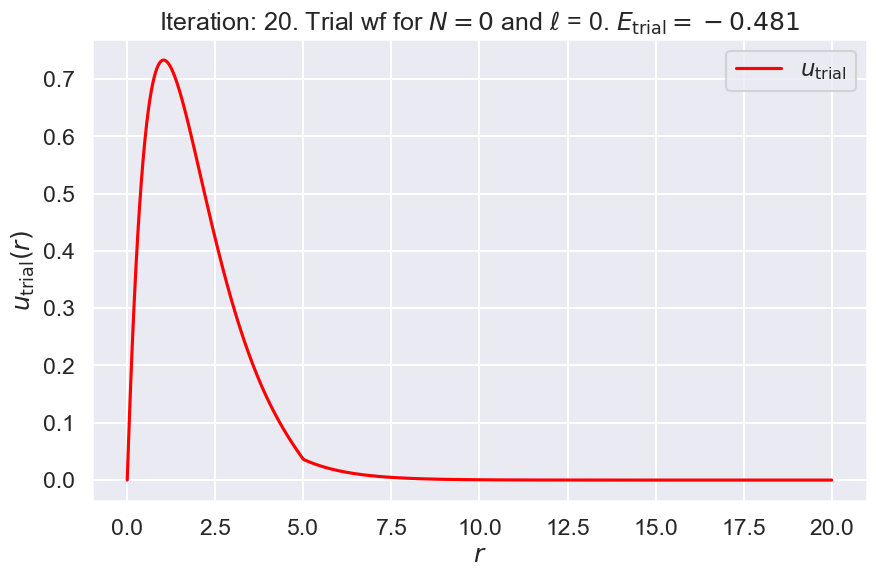

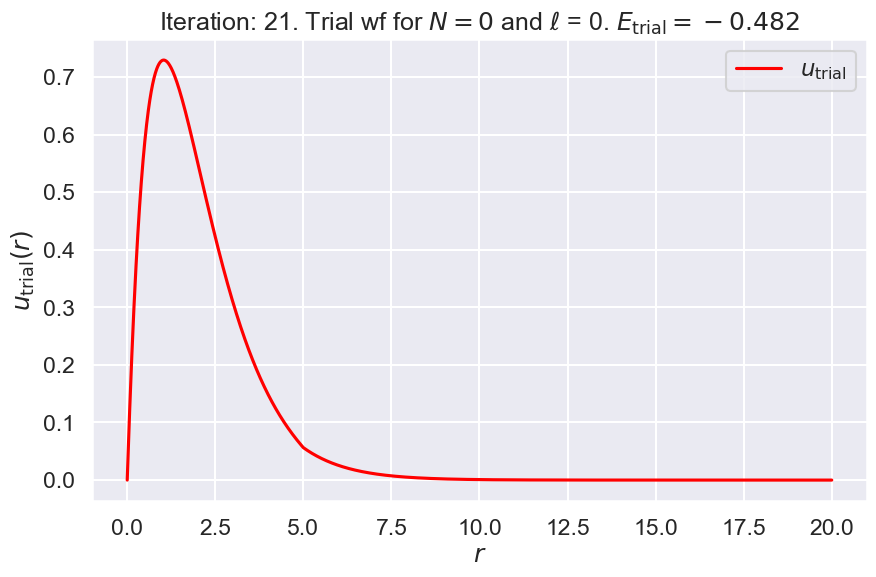

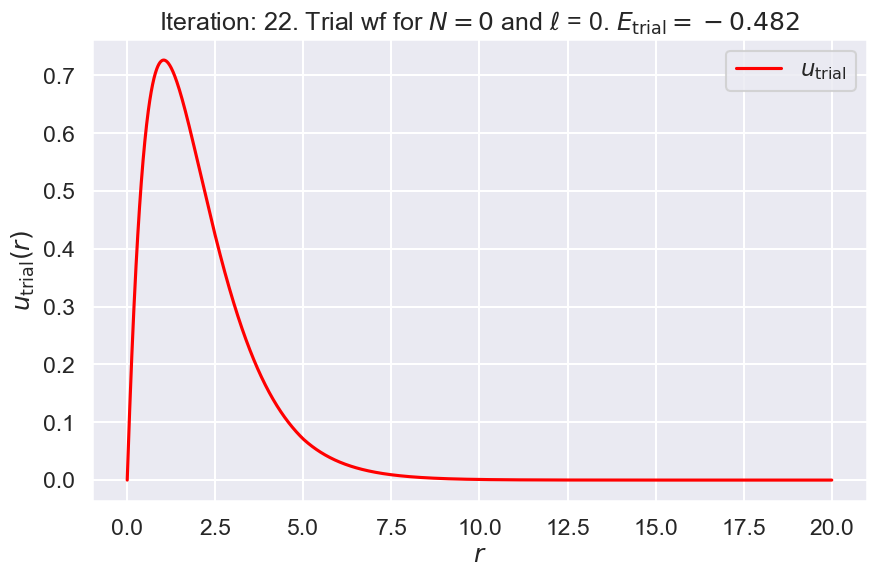

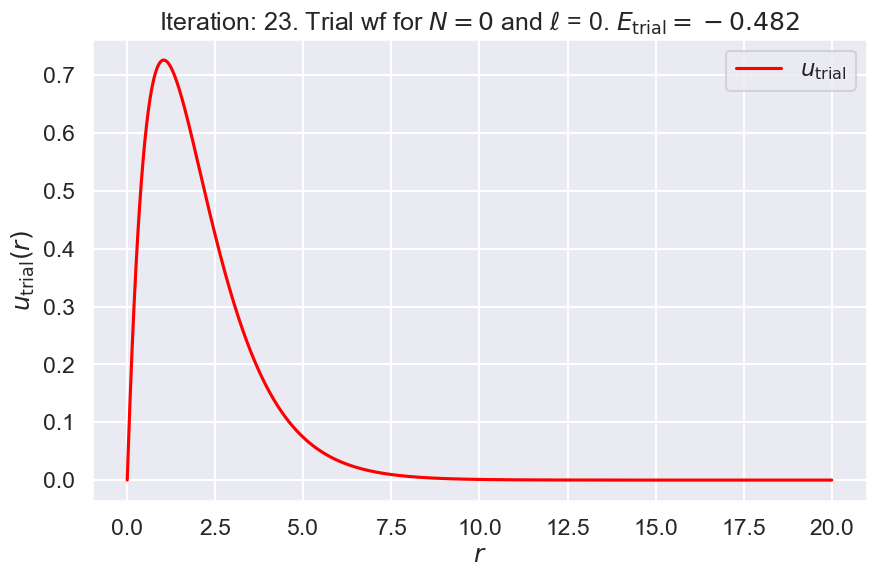

In [7]:
# Evaluate the Coulomb potential on the mesh
V_on_mesh = -Ze_sq / r_mesh[1:] + hbar**2 / (2*mass) * ell * (ell + 1) / r_mesh[1:]**2
u_out[0] = 0

DeltaE_trial = 2 * DeltaE_tol  # initialize DeltaE_trial so there is at least one iteration
iter_num = 0
while np.abs(DeltaE_trial) > DeltaE_tol:
    # initialize the node count and increment the iteration number
    node_count = 0
    iter_num = iter_num + 1
    if iter_num > iter_max:
        print(f' *** Stopped at {iter_num} iterations ***')
        break

    # Set up the array for d^2u/dr^2 
    T_array = 2 * mass / hbar**2 * (V_on_mesh - E_trial)
     
    # integrate out from the origin, with analytic starting points
    u_out[1] = C_out * r_mesh[1]**(ell + 1)
    u_out[2] = C_out * r_mesh[2]**(ell + 1)
    
    for i in np.arange(1, i_match+2):
        u_out[i+1] = 2*u_out[i] - u_out[i-1] + Delta_r**2 * T_array[i] * u_out[i]
        # check for node
        if u_out[i+1] * u_out[i] < 0:
            node_count = node_count + 1
       
    # integrate in from the largest mesh point, using the asymptotic for of u(r)
    kappa = np.sqrt(-2*mass*E_trial / hbar**2)
    u_in[N_pts-1] = D_in * np.exp(-kappa * r_mesh[N_pts-1])
    u_in[N_pts-2] = D_in * np.exp(-kappa * r_mesh[N_pts-2])
    
    for i in np.arange(N_pts-2, i_match-2, -1, dtype=int):
        u_in[i-1] = 2*u_in[i] - u_in[i+1] + Delta_r**2 * T_array[i] * u_in[i]
        # check for node
        if u_in[i-1] * u_in[i] < 0:
            node_count = node_count + 1

    rescale = u_out[i_match] / u_in[i_match]
    u_in = rescale * u_in
        
    # join the out and in solutions at i_match
    u_trial = np.append(u_out[0:i_match], u_in[i_match:])
    
    # normalize the joined and scaled trial wave function u_trial
    u_trial = u_trial / np.sqrt(simps(u_trial**2, r_mesh))
    # print(f'norm check {simps(u_trial**2, r_mesh)}')   # debugging check
    
            
    # adjust trial energy, first by checking if node_count = nodes and then using formula
    if (node_count < nodes):  # too few nodes, increase trial energy by constant
        E_trial = E_trial + DeltaE_nodes
    elif (node_count > nodes):  # too many nodes, decrease trial energy by constant
        E_trial = E_trial - DeltaE_nodes

    else:  # correct no. of nodes; use formula to adjust trial energy         
        u_deriv_out = (u_out[i_match+1] - u_out[i_match-1]) / (2 * Delta_r)
        u_deriv_in = (u_in[i_match+1] - u_in[i_match-1]) / (2 * Delta_r)
        # print(f'u_deriv_out: {u_deriv_out},  u_deriv_in: {u_deriv_in}') # debugging
        
        norm = simps(u_trial**2, r_mesh)  # Should be equal to one
        DeltaE_trial =  -u_trial[i_match] * (u_deriv_in - u_deriv_out) / norm
        new_E_trial = E_trial + DeltaE_trial # New estimate for E_trial
        if new_E_trial > 0:
            E_trial = E_trial + 0.05 * DeltaE_trial
        else:
            E_trial = new_E_trial  
        
        # make a plot of the wave function
        fig = plt.figure(figsize=(10,6))
        
        ax1 = fig.add_subplot(1,1,1)
        ax1.set_xlabel(r'$r$')
        ax1.set_ylabel(r'$u_{\rm trial}(r)$')
        
        #ax1.set_xlim(0, r_max)
        #ax1.set_ylim(-1., 3)
        
        ax1.plot(r_mesh, u_trial, color='red', label=r'$u_{\rm trial}$')
         
        title_string = fr'Iteration: {iter_num}. ' \
                        + fr'Trial wf for $N = {nodes}$ and $\ell$ = {ell}.' \
                        + fr' $E_{{\rm trial}} = {E_trial:.3f}$'
        ax1.set_title(title_string)
        
        ax1.legend();
        

    # print current status
    print(f'\n**** Iteration #{iter_num}' )
    print(f'nodes: {node_count}, E_trial: {E_trial:.4f}, Delta E_trial: {DeltaE_trial:.5f}' )



### 3. Output final result

In [8]:
# Final result
print(f'\n\n *** Calculated energy for {nodes} nodes and angular momentum {ell} is {E_trial:.4f}.' )



 *** Calculated energy for 0 nodes and angular momentum 0 is -0.4821.
